# Variational Autoencoder (VAE)

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset [http://vis-www.cs.umass.edu/lfw/](http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


In [171]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [172]:
% cd /content/drive/My Drive/Session3

/content/drive/My Drive/Session3


In [173]:
% ls

adversarial.ipynb          data.p   lfw_dataset.py  __pycache__/
Autoencoder_structure.png  gan.png  linear.png      vae.ipynb


## Prepare the data

In [174]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [175]:
# The following code fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
# from lfw_dataset import fetch_lfw_dataset
    
# data, attrs = fetch_lfw_dataset()
import pickle
data = pickle.load(open('data.p', 'rb'))

In [176]:
X_train = data[:10000]#.reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:]#.reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 36, 36, 3)
(3143, 36, 36, 3)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [177]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

In [178]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i] * 255, cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

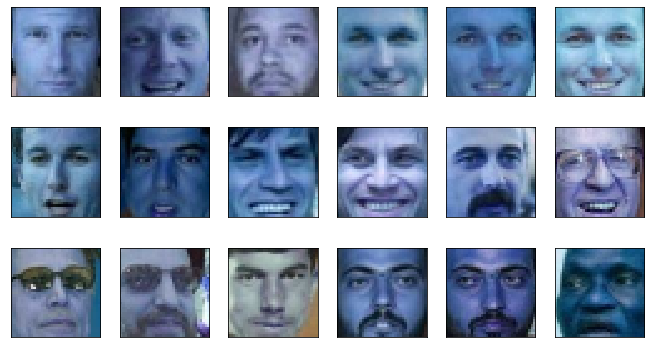

In [179]:
plot_gallery(X_train, image_h, image_w)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="Autoencoder_structure.png" alt="Autoencoder">

In [180]:
X_train.shape

(10000, 36, 36, 3)

In [181]:
import tensorflow as tf
import tensorflow.keras.layers as layers

In [252]:
dimZ = 100 # Considering face reconstruction task, which size of representation seems reasonable?

class AE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(AE, self).__init__()
        self.latent_dim = latent_dim
        # self.input_shape = input_shape
        # self.encoder = tf.keras.Sequential([
        #                    tf.keras.Input(shape=(36,36,3)),
        #                    tf.keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same"),
        #                    tf.keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same"),
        #                    tf.keras.layers.Flatten(),
        #                    tf.keras.layers.Dense(128, activation='relu'),
        #                    tf.keras.layers.Dense(units=self.latent_dim, activation='relu')
        # ]
        # )
        self.encoder = tf.keras.Sequential([
            tf.keras.Input(shape=(36,36,3)),
            layers.Flatten(),
            layers.Dense(768, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),
            layers.Dense(latent_dim, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='zeros')
            ])
        self.decoder = tf.keras.Sequential([
            tf.keras.Input(shape=(self.latent_dim,)),
            layers.Dense(768, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),
            layers.Dense(36*36*3, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='zeros'),
            layers.Reshape((36, 36, 3))
            ])
        # self.decoder = tf.keras.Sequential([
        #                    tf.keras.Input(shape=(self.latent_dim,)),
        #                    tf.keras.layers.Dense(9*9*64, activation='relu'),
        #                    tf.keras.layers.Reshape((9,9,64)),
        #                    tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same"),
        #                    tf.keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same"),
        #                    tf.keras.layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")
        # ]
        # )
    def summary(self):
        self.encoder.summary()
        self.decoder.summary()

    def call(self, input_features):
        code = self.encoder(input_features)
        reconstructed = self.decoder(code)
        return reconstructed

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = tf.reduce_mean(tf.square(tf.subtract(self.call(data), data)))
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # self.total_loss_tracker.update_state(total_loss)
        # self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        # self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": loss
        }

# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics

In [268]:
K.clear_session()
# tf.reset_default_graph()
ae = AE(dimZ)
ae.compile(optimizer=keras.optimizers.Adam())

In [269]:
ae.fit(X_train,  epochs=70, batch_size=32)

Epoch 1/70
313/313 [==============================] - 1s 3ms/step - loss: 0.0048
Epoch 2/70
313/313 [==============================] - 1s 3ms/step - loss: 3.6492e-06
Epoch 3/70
313/313 [==============================] - 1s 3ms/step - loss: 3.5365e-06
Epoch 4/70
313/313 [==============================] - 1s 3ms/step - loss: 3.3547e-06
Epoch 5/70
313/313 [==============================] - 1s 3ms/step - loss: 3.0618e-06
Epoch 6/70
313/313 [==============================] - 1s 3ms/step - loss: 2.5845e-06
Epoch 7/70
313/313 [==============================] - 1s 3ms/step - loss: 1.7750e-06
Epoch 8/70
313/313 [==============================] - 1s 3ms/step - loss: 7.0022e-07
Epoch 9/70
313/313 [==============================] - 1s 3ms/step - loss: 4.8493e-07
Epoch 10/70
313/313 [==============================] - 1s 3ms/step - loss: 4.6322e-07
Epoch 11/70
313/313 [==============================] - 1s 3ms/step - loss: 4.5310e-07
Epoch 12/70
313/313 [==============================] - 1s 3ms/step 

In [270]:
b = ae(X_train)

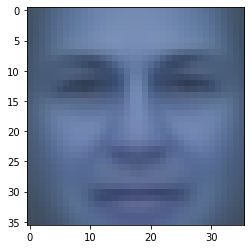

In [272]:
plt.imshow(b[8]*255)

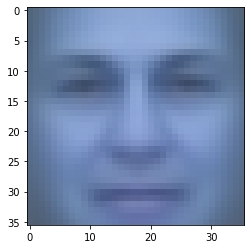

In [273]:
plt.imshow(b[9]*255)